# CNN from scratch

### Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread

import tensorflow as tf
from tensorflow.keras.utils import to_categorical

from skimage.io import imread
from skimage.transform import resize
from PIL import Image

import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import *
from tensorflow.keras.callbacks import *

from numpy import expand_dims

from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Configuration des données

In [4]:
nom_checkpoint_model = "model_Custom_data"
nom_save_weight = "sauv_weights_model_Custom_data"
sauv_dir = "/content/drive/MyDrive/TP_standford/model_Custom_data/"

In [5]:
train_data_dir = "/content/drive/MyDrive/TP_standford/data/"
img_width, img_height = 224, 224 
channels = 3
batch_size = 64
image_arr_size= img_width * img_height * channels

### Phase de preprocessing

In [6]:
train_datagen = ImageDataGenerator(
    rescale= 1./255,
    shear_range= 0.2,
    zoom_range= 0.2,
    horizontal_flip= True,
    rotation_range= 20,
    width_shift_range= 0.2,
    height_shift_range= 0.2,   
    validation_split=0.2,

)

valid_datagen = ImageDataGenerator(
    rescale= 1./255
)

In [7]:
%%time
train_generator = train_datagen.flow_from_directory(  
    train_data_dir,  
    target_size= (img_width, img_height), 
    color_mode= 'rgb',
    batch_size= batch_size,  
    class_mode= 'categorical',
    subset='training',
    shuffle= True, 
    seed= 1337
) 

valid_generator = valid_datagen.flow_from_directory(
    train_data_dir,
    target_size= (img_width, img_height),
    color_mode= 'rgb',
    batch_size= batch_size,  
    class_mode= 'categorical',
    subset='validation',
    shuffle= True, 
    seed= 1337
)

Found 16507 images belonging to 120 classes.
Found 4072 images belonging to 120 classes.
CPU times: user 627 ms, sys: 73.2 ms, total: 700 ms
Wall time: 40 s


In [ ]:
# Nombre de classes (120 races)
num_classes = len(train_generator.class_indices)

# Encodage des labels de l'échantillon de train
# Ressource : https://stackoverflow.com/questions/41494625/issues-using-keras-np-utils-to-categorical/43314437
train_labels = train_generator.classes 
train_labels = to_categorical(train_labels, num_classes=num_classes)

# Encodage des labels de l'échantillon de validation
valid_labels = valid_generator.classes 
valid_labels = to_categorical(valid_labels, num_classes=num_classes)

nb_train_samples = len(train_generator.filenames)  
nb_valid_samples = len(valid_generator.filenames)

### Visualisation de la data augmentation

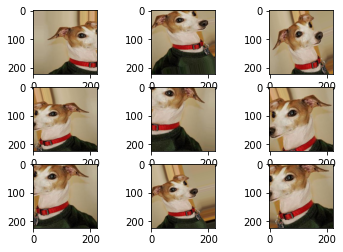

In [ ]:
# On prend une image aléatoirement : n02091032-Italian_greyhound/n02091032_55.jpg
img = load_img('/content/drive/MyDrive/TP_standford/data/n02091032-Italian_greyhound/n02091032_55.jpg')

# Conversion en array
data = img_to_array(img)
samples = expand_dims(data, 0)
it = train_datagen.flow(samples, batch_size=1)

# On affiche 9 images pour visualiser la data augmentation
for i in range(9):
    plt.subplot(330 + 1 + i)
    batch = it.next()
    image = batch[0]
    plt.imshow(image)

plt.show()

### Visualisation des labels (targets)

In [ ]:
# Visualisation des labels
label_maps = {}
for i, v in enumerate(train_generator.class_indices):
    label_maps.update({i:v})
print(f'{len(label_maps)} races')

120 races


In [ ]:
label_maps

{0: 'n02085620-Chihuahua',
 1: 'n02085782-Japanese_spaniel',
 2: 'n02085936-Maltese_dog',
 3: 'n02086079-Pekinese',
 4: 'n02086240-Shih-Tzu',
 5: 'n02086646-Blenheim_spaniel',
 6: 'n02086910-papillon',
 7: 'n02087046-toy_terrier',
 8: 'n02087394-Rhodesian_ridgeback',
 9: 'n02088094-Afghan_hound',
 10: 'n02088238-basset',
 11: 'n02088364-beagle',
 12: 'n02088466-bloodhound',
 13: 'n02088632-bluetick',
 14: 'n02089078-black-and-tan_coonhound',
 15: 'n02089867-Walker_hound',
 16: 'n02089973-English_foxhound',
 17: 'n02090379-redbone',
 18: 'n02090622-borzoi',
 19: 'n02090721-Irish_wolfhound',
 20: 'n02091032-Italian_greyhound',
 21: 'n02091134-whippet',
 22: 'n02091244-Ibizan_hound',
 23: 'n02091467-Norwegian_elkhound',
 24: 'n02091635-otterhound',
 25: 'n02091831-Saluki',
 26: 'n02092002-Scottish_deerhound',
 27: 'n02092339-Weimaraner',
 28: 'n02093256-Staffordshire_bullterrier',
 29: 'n02093428-American_Staffordshire_terrier',
 30: 'n02093647-Bedlington_terrier',
 31: 'n02093754-Border_

### Création du réseau de neurone from scratch

**Ressources pour comprendre les couches**
- https://machinelearningmastery.com/how-to-accelerate-learning-of-deep-neural-networks-with-batch-normalization/
-  https://machinelearningmastery.com/pooling-layers-for-convolutional-neural-networks/

In [ ]:
model = Sequential()

# Couche d'entrée : prend en compte la shape de nos images !
model.add(Conv2D(16, (3, 3), padding='same', use_bias=False, input_shape=(img_width, img_height, channels)))
model.add(BatchNormalization(axis=3, scale=False))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'))
model.add(Dropout(0.2))

# Couche supplémentaire
model.add(Conv2D(32, (3, 3), padding='same', use_bias=False))
model.add(BatchNormalization(axis=3, scale=False))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'))
model.add(Dropout(0.2))

# Couche supplémentaire
model.add(Conv2D(64, (3, 3), padding='same', use_bias=False))
model.add(BatchNormalization(axis=3, scale=False))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'))
model.add(Dropout(0.2))

# Couche supplémentaire
model.add(Conv2D(128, (3, 3), padding='same', use_bias=False))
model.add(BatchNormalization(axis=3, scale=False))
model.add(Activation("relu"))
model.add(Flatten())
model.add(Dropout(0.2))

# Couches connectées, couche de sortie prend en compte le nombre de classe num_classes !
model.add(Dense(512, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      432       
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 16)      48        
_________________________________________________________________
activation (Activation)      (None, 224, 224, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 56, 56, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 56, 56, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 56, 56, 32)        4608      
_________________________________________________________________
batch_normalization_1 (Batch (None, 56, 56, 32)        9

#### Compilation du modèle

In [ ]:
model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

#### Phase d'entrainement du modèle

Après plusieurs tests et plusieurs lancements d'entrainement de CNN, j'ai ajouté : 
- un `ModelCheckpoint` pour sauvegarder le meilleur modèle à chaque epoch dans un fichier **.h5**
- un `EarlyStopping` pour lutter contre le surapprentissage !
- un `CSVLogger` qui permet de logger à chaque epoch les métriques du modèle (accuracy, loss, etc)
- un `ReduceLROnPlateau` pour agir sur le learning rate du modèle à chaque epoch

In [ ]:
checkpoint = ModelCheckpoint(
    sauv_dir+nom_checkpoint_model+'.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='auto',
    save_weights_only=False,
    period=1
)

earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=3,
    verbose=1,
    mode='auto'
)

csvlogger = CSVLogger(
    filename= sauv_dir+"training_csv.log",
    separator = ",",
    append = False
)

reduceLR = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1, 
    mode='auto'
)

# On enregistre dans un tableau callbacks, qu'on va fournir lors de l'entrainement du modèle
callbacks = [checkpoint, csvlogger,reduceLR]

In [ ]:
%%time
history = model.fit(
    train_generator,
    epochs = 30,
    steps_per_epoch = nb_train_samples//batch_size,
    validation_data = valid_generator, 
    validation_steps = nb_valid_samples//batch_size,
    verbose = 1, 
    callbacks = callbacks
)

Epoch 1/30
257/257 [==============================] - 7236s 28s/step - loss: 4.7927 - accuracy: 0.0177 - val_loss: 6.8319 - val_accuracy: 0.0156

Epoch 00001: val_loss improved from inf to 6.83194, saving model to /content/drive/MyDrive/TP_standford/Custom_30e120c_datav4/model_Custom_30e120c_datav4.h5
Epoch 2/30
257/257 [==============================] - 197s 765ms/step - loss: 4.3304 - accuracy: 0.0487 - val_loss: 5.4585 - val_accuracy: 0.0159

Epoch 00002: val_loss improved from 6.83194 to 5.45851, saving model to /content/drive/MyDrive/TP_standford/Custom_30e120c_datav4/model_Custom_30e120c_datav4.h5
Epoch 3/30
257/257 [==============================] - 197s 766ms/step - loss: 4.1138 - accuracy: 0.0643 - val_loss: 4.4454 - val_accuracy: 0.0501

Epoch 00003: val_loss improved from 5.45851 to 4.44542, saving model to /content/drive/MyDrive/TP_standford/Custom_30e120c_datav4/model_Custom_30e120c_datav4.h5
Epoch 4/30
257/257 [==============================] - 195s 759ms/step - loss: 3.9

### Affichage des métriques

In [ ]:
(eval_loss, eval_accuracy) = model.evaluate(valid_generator, batch_size= batch_size, verbose= 1)
print('Validation Loss: ', eval_loss)
print('Validation Accuracy: ', eval_accuracy)

64/64 [==============================] - 10s 158ms/step - loss: 3.5410 - accuracy: 0.1640
Validation Loss:  3.5409648418426514
Validation Accuracy:  0.16404715180397034


### Visualisation en plot des courbes d'apprentissage

In [ ]:
plt.rcParams['figure.figsize'] = (6,6)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.savefig(sauv_dir+'baseline_acc_epoch.png', transparent= False, bbox_inches= 'tight', dpi= 900)
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')
plt.savefig(sauv_dir+'baseline_loss_epoch.png', transparent= False, bbox_inches= 'tight', dpi= 900)

plt.legend()

plt.show()

### Enregistrement des poids du modèle

In [ ]:
model.save_weights(sauv_dir+nom_save_weight+'/ckpt')